# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 200 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

## Important Caveats:

- The confirmed cases reported by each country is different from the actual number of cases in each country (many of which are not tested). 

- Confirmed cases and actual cases grow at different rates. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but the actual cases may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [31]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,43,47,48,50,50,50,53,59,70,75
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,331,360,420,461,502,511,581,639,639,701
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,110,117,130,138,150,150,160,178,178,200
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,50,83,93,99,117,129,149,149,197
5,British Columbia,Canada,49.2827,-123.1207,0,0,0,0,0,0,...,12,13,21,21,27,32,32,39,46,64
6,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,22,22,26,28,38,48,55,65,65,92
7,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,10,10,10,11,11,15,18,21,21,36
8,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,...,11,13,13,13,15,15,18,20,20,35
9,NaN,Cambodia,11.5500,104.9167,0,0,0,0,0,1,...,1,1,1,1,2,2,2,3,3,5


## Global COVID-19 Analysis

In [6]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 200]
cases


Total number of cases (in countries with at least 100 cases) as of 3/13/20


,3/13/20
Country/Region,
China,80945
Italy,17660
Iran,11364
"Korea, South",7979
Spain,5232
Germany,3675
France,3667
US,2179
Switzerland,1139


## Curve Fitting Global COVID-19 Cases

In [28]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 80945
	Confirmed cases on 3/6/20 	 80690
	Ratio: 1.0
	Weekly increase: 0.3 %
	Daily increase: 0.0 % per day
	Doubling Time (represents recent growth): 1537.8 days

** Based on Logistic Fit**

	R^2: 0.994888762219
	Doubling Time (during middle of growth):  6.46 (± 0.6 ) days


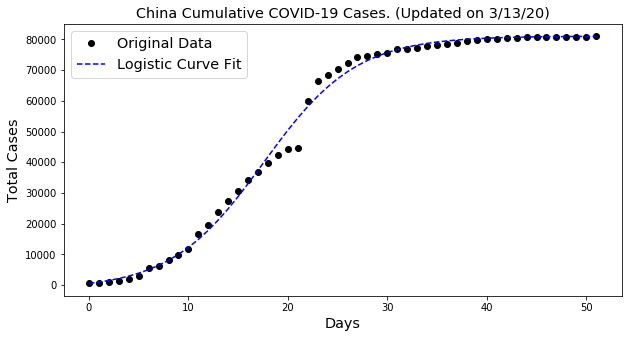



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 17660
	Confirmed cases on 3/6/20 	 4636
	Ratio: 3.81
	Weekly increase: 280.9 %
	Daily increase: 21.1 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.992837942237
	Doubling Time (during middle of growth):  6.12 (± 0.97 ) days

** Based on Exponential Fit **

	R^2: 0.991280994582
	Doubling Time (represents overall growth):  3.76 (± 0.23 ) days


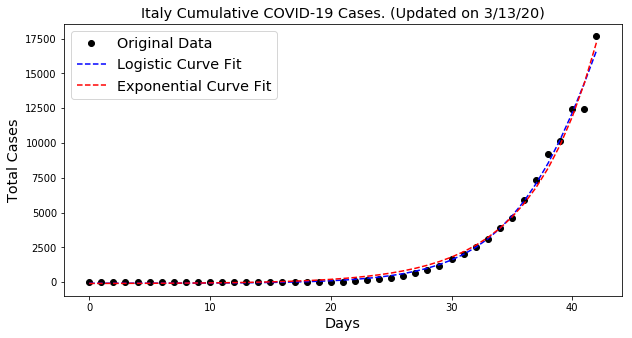



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 11364
	Confirmed cases on 3/6/20 	 4747
	Ratio: 2.39
	Weekly increase: 139.4 %
	Daily increase: 13.3 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.996109664681
	Doubling Time (during middle of growth):  4.71 (± 0.71 ) days


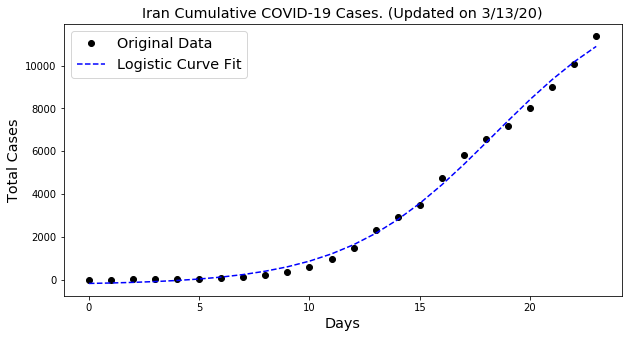



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 7979
	Confirmed cases on 3/6/20 	 6593
	Ratio: 1.21
	Weekly increase: 21.0 %
	Daily increase: 2.8 % per day
	Doubling Time (represents recent growth): 25.4 days

** Based on Logistic Fit**

	R^2: 0.999591287605
	Doubling Time (during middle of growth):  3.95 (± 0.11 ) days


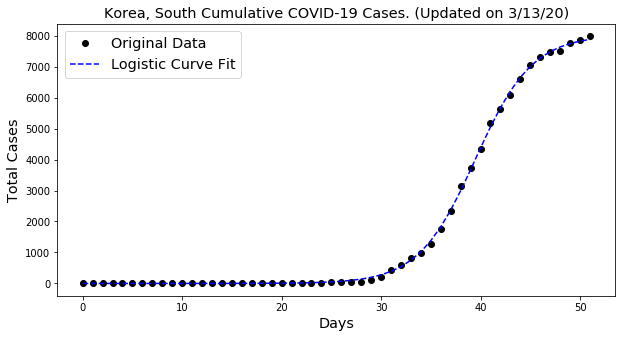



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 5232
	Confirmed cases on 3/6/20 	 400
	Ratio: 13.08
	Weekly increase: 1208.0 %
	Daily increase: 44.4 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Exponential Fit **

	R^2: 0.968262403943
	Doubling Time (represents overall growth):  1.69 (± 0.2 ) days


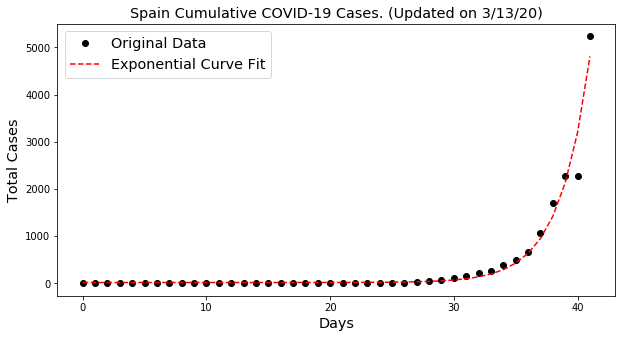



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 3675
	Confirmed cases on 3/6/20 	 670
	Ratio: 5.49
	Weekly increase: 448.5 %
	Daily increase: 27.5 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.981448451839
	Doubling Time (represents overall growth):  2.58 (± 0.22 ) days


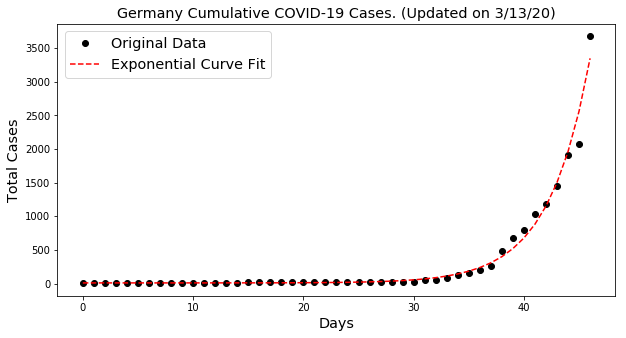



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 3667
	Confirmed cases on 3/6/20 	 656
	Ratio: 5.59
	Weekly increase: 459.0 %
	Daily increase: 27.9 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.986617796591
	Doubling Time (represents overall growth):  2.79 (± 0.19 ) days


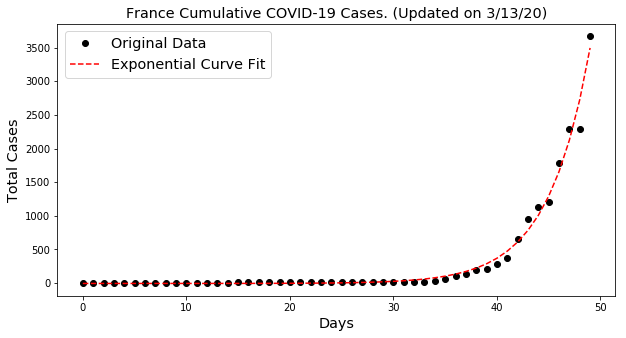



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 2179
	Confirmed cases on 3/6/20 	 262
	Ratio: 8.32
	Weekly increase: 731.7 %
	Daily increase: 35.3 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Exponential Fit **

	R^2: 0.997764260369
	Doubling Time (represents overall growth):  2.35 (± 0.06 ) days


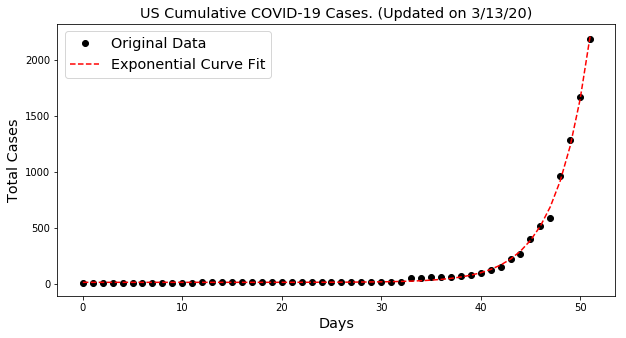



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 1139
	Confirmed cases on 3/6/20 	 214
	Ratio: 5.32
	Weekly increase: 432.2 %
	Daily increase: 27.0 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Logistic Fit**

	R^2: 0.974905476862
	Doubling Time (during middle of growth):  5.67 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.974905478756
	Doubling Time (represents overall growth):  2.83 (± 0.58 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


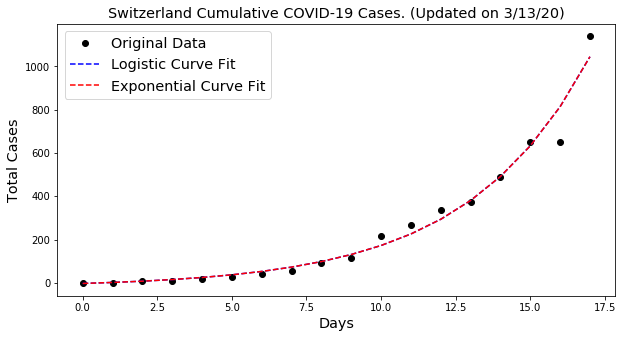



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 996
	Confirmed cases on 3/6/20 	 108
	Ratio: 9.22
	Weekly increase: 822.2 %
	Daily increase: 37.4 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.991954556683
	Doubling Time (during middle of growth):  3.53 (± 1.21 ) days

** Based on Exponential Fit **

	R^2: 0.991315538252
	Doubling Time (represents overall growth):  2.17 (± 0.25 ) days


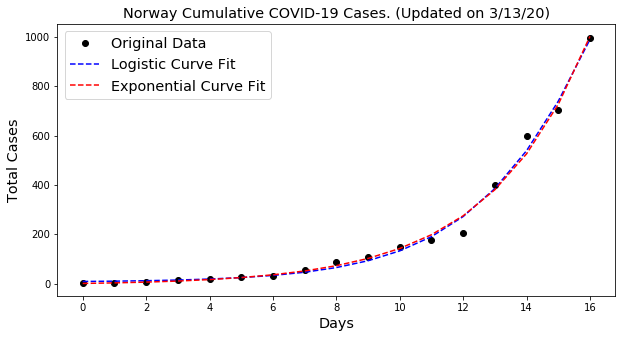



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 814
	Confirmed cases on 3/6/20 	 101
	Ratio: 8.06
	Weekly increase: 705.9 %
	Daily increase: 34.7 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Exponential Fit **

	R^2: 0.996602600835
	Doubling Time (represents overall growth):  2.43 (± 0.09 ) days


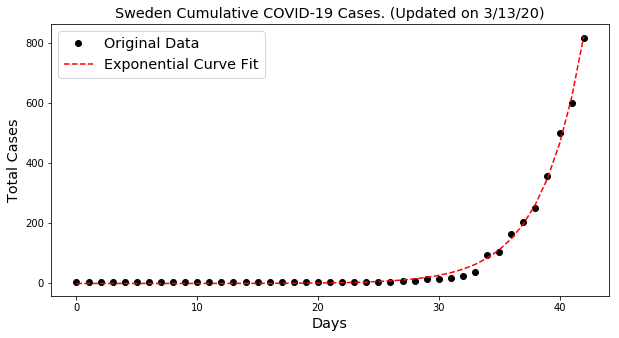



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 804
	Confirmed cases on 3/6/20 	 24
	Ratio: 33.5
	Weekly increase: 3250.0 %
	Daily increase: 65.1 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Logistic Fit**

	R^2: 0.997578456874
	Doubling Time (during middle of growth):  1.52 (± 0.21 ) days

** Based on Exponential Fit **

	R^2: 0.97768601934
	Doubling Time (represents overall growth):  1.74 (± 0.33 ) days


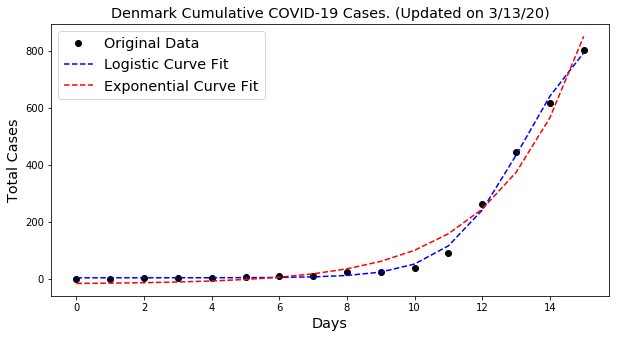



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 804
	Confirmed cases on 3/6/20 	 128
	Ratio: 6.28
	Weekly increase: 528.1 %
	Daily increase: 30.0 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.980069391975
	Doubling Time (during middle of growth):  6.55 (± 6.83 ) days

** Based on Exponential Fit **

	R^2: 0.980069393728
	Doubling Time (represents overall growth):  3.27 (± 0.74 ) days


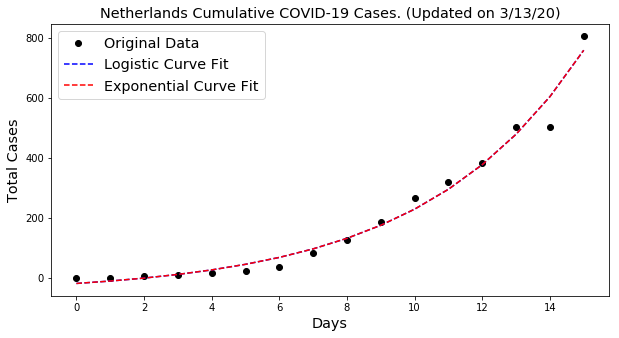



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 801
	Confirmed cases on 3/6/20 	 164
	Ratio: 4.88
	Weekly increase: 388.4 %
	Daily increase: 25.4 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.978440005854
	Doubling Time (represents overall growth):  3.01 (± 0.29 ) days


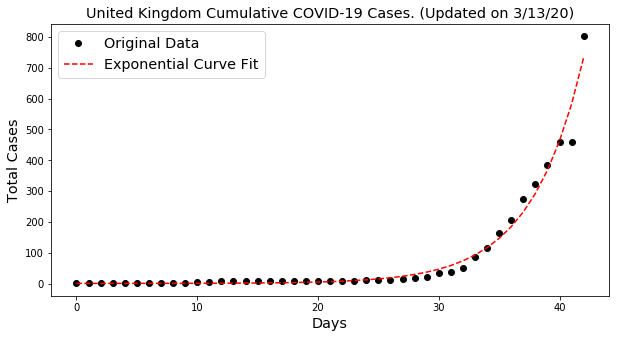



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 701
	Confirmed cases on 3/6/20 	 420
	Ratio: 1.67
	Weekly increase: 66.9 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.5 days

** Based on Logistic Fit**

	R^2: 0.996750996109
	Doubling Time (during middle of growth):  12.4 (± 1.39 ) days

** Based on Exponential Fit **

	R^2: 0.995218931118
	Doubling Time (represents overall growth):  8.35 (± 0.41 ) days


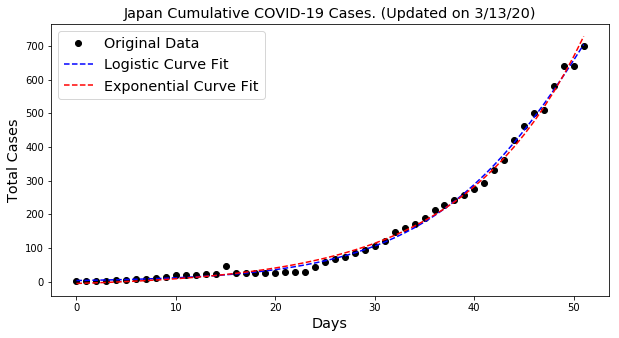



Cruise Ship

** Based on Logistic Fit**

	R^2: 0.995510032851
	Doubling Time (during middle of growth):  2.69 (± 0.3 ) days


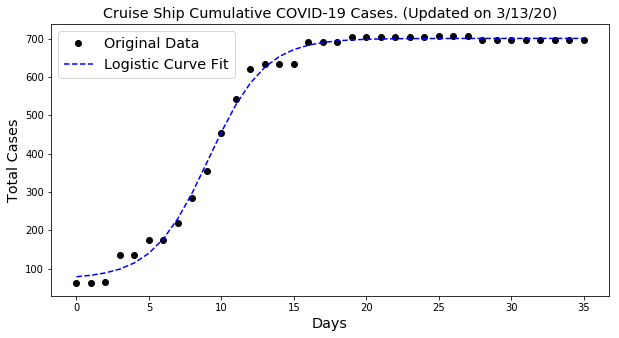



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 559
	Confirmed cases on 3/6/20 	 109
	Ratio: 5.13
	Weekly increase: 412.8 %
	Daily increase: 26.3 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Exponential Fit **

	R^2: 0.96266458239
	Doubling Time (represents overall growth):  2.94 (± 0.4 ) days


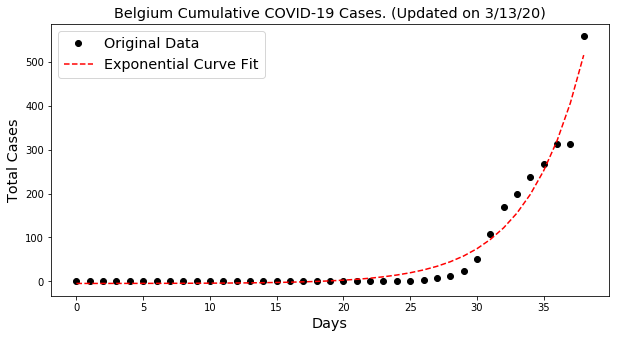



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 504
	Confirmed cases on 3/6/20 	 55
	Ratio: 9.16
	Weekly increase: 816.4 %
	Daily increase: 37.2 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.991055391987
	Doubling Time (during middle of growth):  4.11 (± 0.71 ) days

** Based on Exponential Fit **

	R^2: 0.991055392287
	Doubling Time (represents overall growth):  2.06 (± 0.23 ) days


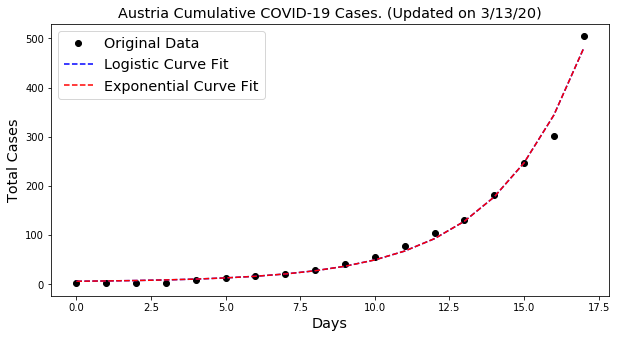



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 320
	Confirmed cases on 3/6/20 	 8
	Ratio: 40.0
	Weekly increase: 3900.0 %
	Daily increase: 69.4 % per day
	Doubling Time (represents recent growth): 1.3 days

** Based on Logistic Fit**

	R^2: 0.98918671809
	Doubling Time (during middle of growth):  0.28 (± 0.12 ) days


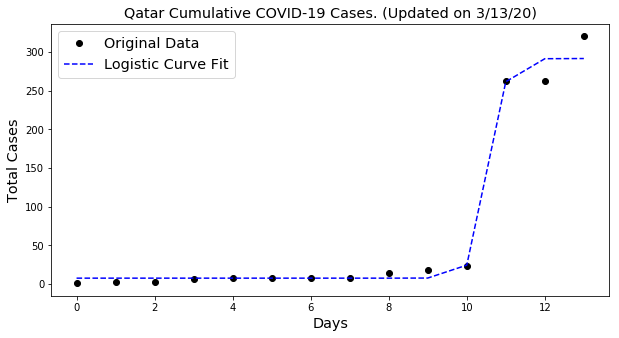



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 200
	Confirmed cases on 3/6/20 	 60
	Ratio: 3.33
	Weekly increase: 233.3 %
	Daily increase: 18.8 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Exponential Fit **

	R^2: 0.979287414239
	Doubling Time (represents overall growth):  3.65 (± 0.33 ) days


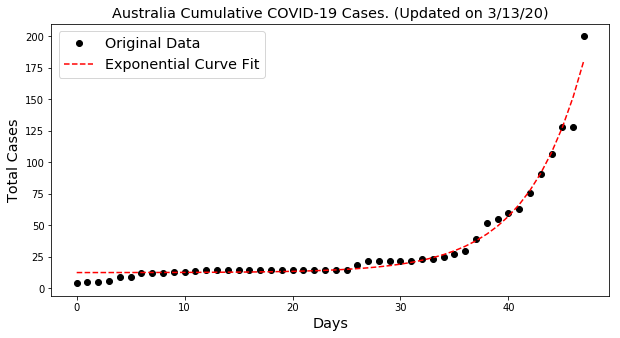



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 200
	Confirmed cases on 3/6/20 	 130
	Ratio: 1.54
	Weekly increase: 53.8 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.3 days

** Based on Logistic Fit**

	R^2: 0.973048663275
	Doubling Time (during middle of growth):  63.09 (± 36.01 ) days

** Based on Exponential Fit **

	R^2: 0.973048664425
	Doubling Time (represents overall growth):  31.54 (± 10.58 ) days


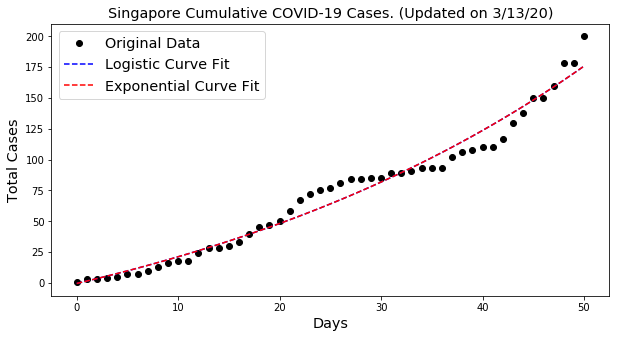

In [29]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


         Countries  Inferred Doubling Time  Recent Doubling Time
0            China                     6.5                1537.8
1            Italy                     3.8                   3.6
2             Iran                     4.7                   5.6
3     Korea, South                     4.0                  25.4
4            Spain                     1.7                   1.9
5          Germany                     2.6                   2.9
6           France                     2.8                   2.8
7               US                     2.3                   2.3
8      Switzerland                     2.8                   2.9
9           Norway                     2.2                   2.2
10          Sweden                     2.4                   2.3
11         D

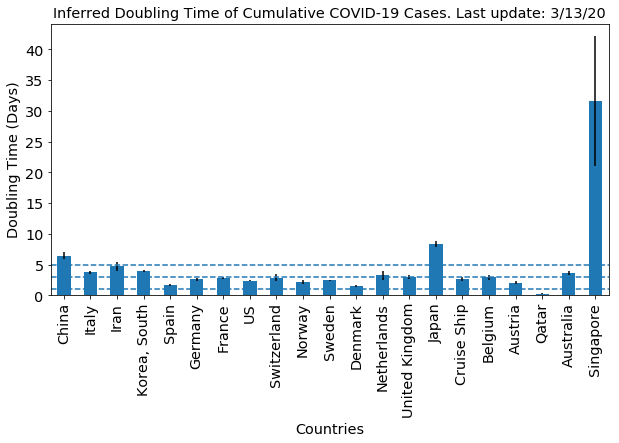

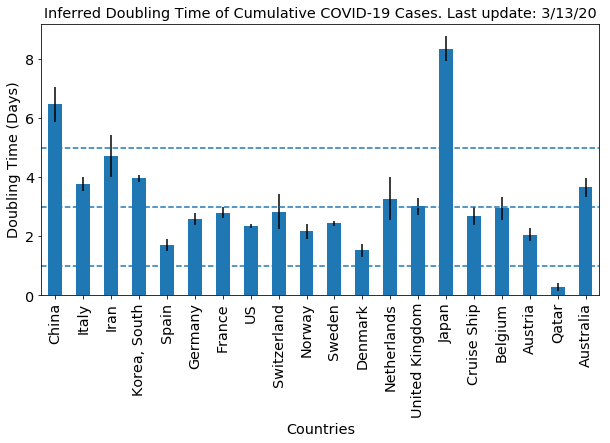

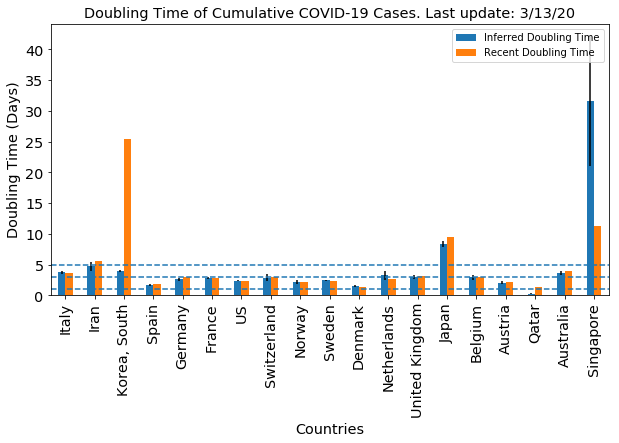

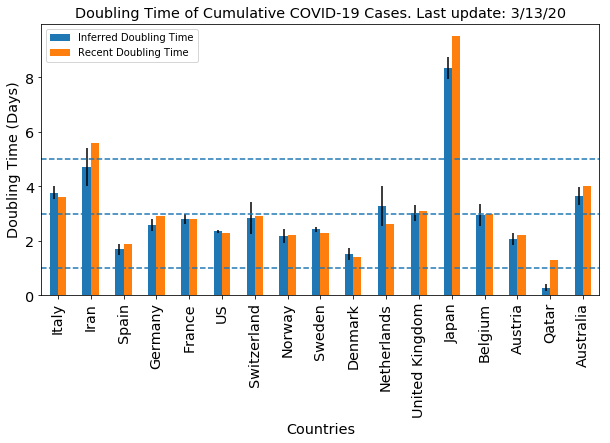

In [30]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(10,5), fontsize="x-large", yerr=err)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(10,5), fontsize="x-large", yerr=err)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [21]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    if ',' in location:
        result = [x.strip() for x in location.split(',')]
        statename = states[result[1]]
        row['State'] = statename
        uscases.loc[index, 'Province/State'] = statename

usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/13/20


,3/13/20
Province/State,
Washington,568
New York,421
California,282
Massachusetts,123
Florida,50
Colorado,49
Illinois,46
Diamond Princess,46
Texas,43


## Curve Fitting US COVID-19 Cases

                3/13/20
Province/State         
Washington          568
New York            421
California          282


US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 568
	Confirmed cases on 3/6/20 	 78
	Ratio: 7.28
	Weekly increase: 628.2 %
	Daily increase: 32.8 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Exponential Fit **

	R^2: 0.990109150822
	Doubling Time (represents overall growth):  2.35 (± 0.14 ) days


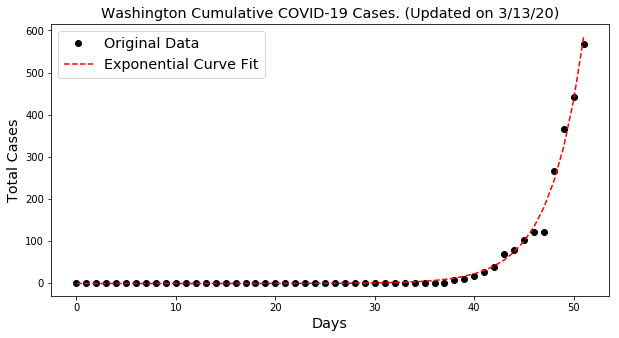



US state:  New York

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 421
	Confirmed cases on 3/6/20 	 31
	Ratio: 13.58
	Weekly increase: 1258.1 %
	Daily increase: 45.2 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Logistic Fit**

	R^2: 0.994754444512
	Doubling Time (during middle of growth):  5.42 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.994754444737
	Doubling Time (represents overall growth):  2.71 (± 0.4 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt


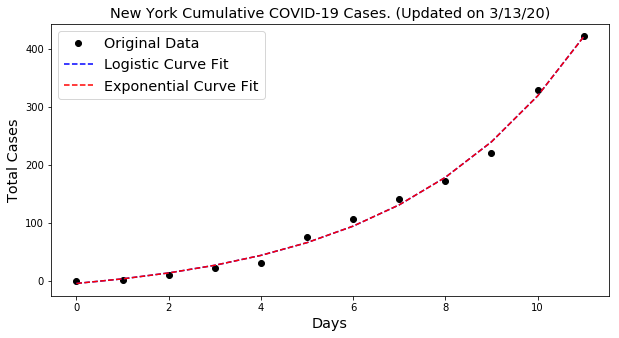



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/13/20 	 282
	Confirmed cases on 3/6/20 	 59
	Ratio: 4.78
	Weekly increase: 378.0 %
	Daily increase: 25.0 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.996375719639
	Doubling Time (represents overall growth):  2.9 (± 0.11 ) days


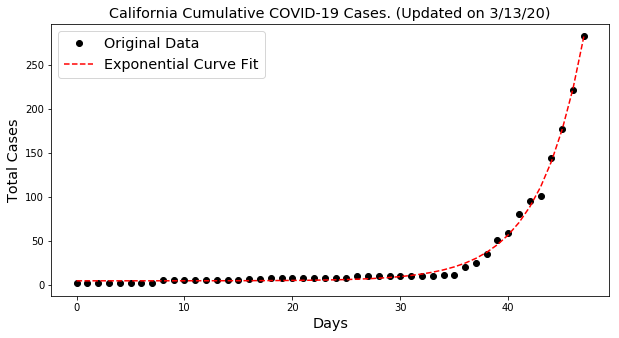

In [22]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 200]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


       States  Inferred Doubling Time  Recent Doubling Time
0  Washington                     2.4                   2.4
1    New York                     2.7                   1.9
2  California                     2.9                   3.1




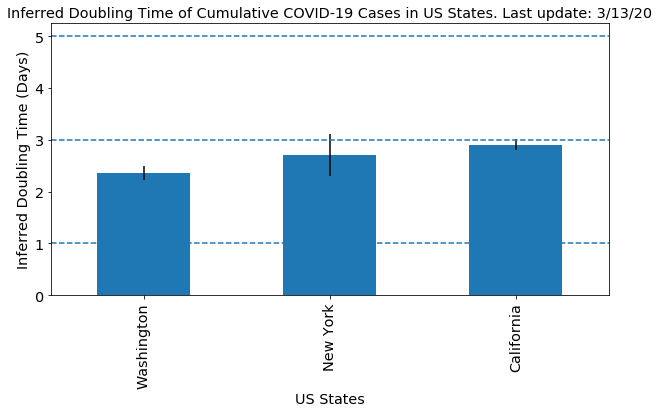

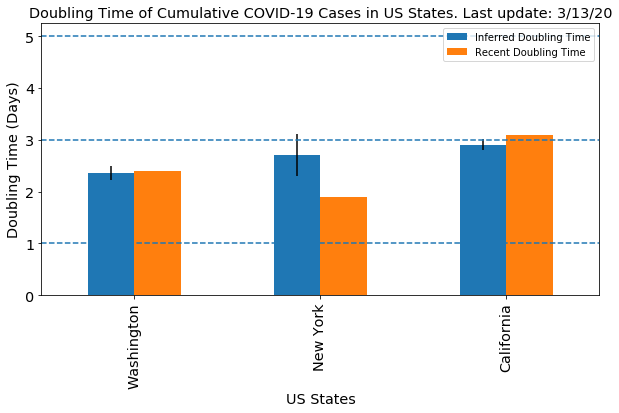

In [26]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()